In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

%matplotlib inline

## Read in the data

In [23]:
# read in the data (version with complexity imputed)
df = pd.read_csv("../Data/Hawaii_RegimesPredictors_complete.txt", sep="\t", decimal=",")
train = pd.read_csv("../Data/Modeling/Predictors_complete_train.txt", sep='\t', decimal=",")
test = pd.read_csv("../Data/Modeling/Predictors_complete_test.txt", sep='\t', decimal=",")

## Split into train and test

In [24]:
#Comment out data prep if running VIF
def data_prep(df):
    df = df.astype({"id_spatial": "category", "Island": "category", "Habitat_Modification": "category", 
               "Invasive_Algae": "category", "Regime": "category", "Regime1": "category", 
               "Regime2": "category", "Regime3": "category", "Regime5": "category"})
    return df

In [25]:
df = data_prep(df)
train = data_prep(train)
test = data_prep(test)

In [26]:
train.dtypes

Unnamed: 0                        int64
id_spatial                     category
Long                            float64
Lat                             float64
Island                         category
Coral                           float64
CCA                             float64
Turf                            float64
Macro                           float64
Other                           float64
Grazers                         float64
Scrapers                        float64
Browsers                        float64
Predators                       float64
Secondary                       float64
Effluent                        float64
Sedimentation                   float64
New_Development                 float64
Habitat_Modification           category
Invasive_Algae                 category
Fishing_Comm_Total              float64
Fishing_NonComm_Boat_Total      float64
Fishing_NonComm_Shore_Line      float64
Fishing_NonComm_Shore_Net       float64
Fishing_NonComm_Shore_Spear     float64


## Logistic Regression

##### Split data into train and test set

In [27]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

test_X = test.iloc[:, 14:34]
test_y = test['Regime']

In [20]:
pred_names = df.iloc[:, 14:34].columns

In [29]:
train_X.dtypes

Secondary                       float64
Effluent                        float64
Sedimentation                   float64
New_Development                 float64
Habitat_Modification           category
Invasive_Algae                 category
Fishing_Comm_Total              float64
Fishing_NonComm_Boat_Total      float64
Fishing_NonComm_Shore_Line      float64
Fishing_NonComm_Shore_Net       float64
Fishing_NonComm_Shore_Spear     float64
SST_CLIM_M                      float64
SST_STD                         float64
CHL_CLIM_M                      float64
CHL_ANOM_F                      float64
PAR_CLIM_M                      float64
PAR_STD                         float64
WAV_CLIM_M                      float64
WAV_ANOM_F                      float64
Complexity                      float64
dtype: object

##### Standardize the data

In [30]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
test_X = scaler.transform(test_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


##### Helper functions for modeling

In [31]:
def pretty_print_performance(test_y, test_pred, print_vals=True):
    cnf_matrix = metrics.confusion_matrix(test_y, test_pred)
    
    class_names=['Reg 1', 'Reg 2', 'Reg 3', 'Reg 5']
    cnf_matrix = pd.DataFrame(cnf_matrix, index = class_names,
                  columns = class_names)
    
    # plot confusion matrix with heatmap
    sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if print_vals :
        count_misclassified = (test_y != test_pred).sum()
        print('Misclassified samples: {}'.format(count_misclassified))
        accuracy = metrics.accuracy_score(test_y, test_pred)    
        print('Classification Report:')
        print(metrics.classification_report(test_y, test_pred))  

def microaveage_F1(test_y, test_pred):
    return metrics.classification_report(test_y, test_pred, output_dict=True)['weighted avg']['f1-score']

### Multiclass logistic regression model (one vs. rest)

##### Fit the model & make predictions

In [32]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr')
clf.fit(train_X, train_y)
#clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
# make predictions
test_pred = clf.predict(test_X)

##### Evaluate performance

Misclassified samples: 39
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.75      0.78        44
           2       0.69      0.68      0.68        37
           3       0.52      0.64      0.57        25
           5       0.69      0.61      0.65        18

   micro avg       0.69      0.69      0.69       124
   macro avg       0.68      0.67      0.67       124
weighted avg       0.70      0.69      0.69       124



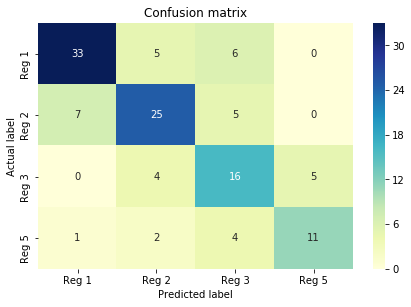

In [34]:
pretty_print_performance(test_y, test_pred)

##### Examining variable importance
Since this is no longer a focus for the project, I'm not doing this for the other models. Just keeping this here in case we want to revisit it for the final project writeup.

In [35]:
# create a data frame with the coefficients for all the multiclass logit coefficients
coef_ovr = pd.DataFrame(clf.coef_, index=clf.classes_, columns=pred_names)

In [36]:
# sort predictors by the magnitude of their coefficients for regime 1
np.abs(coef_ovr.iloc[[0,]]).sort_values(by=1, axis=1, ascending=False)

,Effluent,Depth,Fishing_NonComm_Shore_Line,SST_STD,Fishing_NonComm_Boat_Total,SST_CLIM_M,PAR_CLIM_M,Invasive_Algae,CHL_CLIM_M,Fishing_NonComm_Shore_Spear,Fishing_NonComm_Shore_Net,PAR_STD,Habitat_Modification,Complexity,Sedimentation,Fishing_Comm_Total,CHL_ANOM_F,WAV_ANOM_F,WAV_CLIM_M,New_Development
1,2.730324,0.684462,0.672694,0.663619,0.522909,0.404894,0.223973,0.188662,0.183378,0.157403,0.156011,0.104799,0.097732,0.063223,0.052159,0.051915,0.049917,0.017792,0.014935,0.00626


In [37]:
# for regime 2
np.abs(coef_ovr.iloc[[1,]]).sort_values(by=2, axis=1, ascending=False)

,SST_STD,WAV_ANOM_F,Effluent,CHL_CLIM_M,PAR_CLIM_M,Complexity,Fishing_NonComm_Shore_Spear,Fishing_NonComm_Shore_Line,Fishing_NonComm_Boat_Total,New_Development,Fishing_Comm_Total,SST_CLIM_M,Habitat_Modification,Depth,Invasive_Algae,WAV_CLIM_M,Fishing_NonComm_Shore_Net,Sedimentation,CHL_ANOM_F,PAR_STD
2,0.759001,0.517907,0.444405,0.442679,0.425991,0.321575,0.300088,0.28406,0.275976,0.271115,0.240211,0.224184,0.217441,0.181255,0.128938,0.097616,0.064584,0.044908,0.020336,0.007527


In [38]:
# for regime 3
np.abs(coef_ovr.iloc[[2,]]).sort_values(by=3, axis=1, ascending=False)

,SST_STD,Fishing_NonComm_Shore_Spear,CHL_ANOM_F,Fishing_Comm_Total,CHL_CLIM_M,Effluent,Fishing_NonComm_Boat_Total,New_Development,WAV_CLIM_M,PAR_CLIM_M,Fishing_NonComm_Shore_Net,WAV_ANOM_F,Habitat_Modification,Fishing_NonComm_Shore_Line,Complexity,PAR_STD,Invasive_Algae,SST_CLIM_M,Depth,Sedimentation
3,1.002872,0.65047,0.649518,0.64853,0.485345,0.397026,0.379915,0.335152,0.308862,0.29202,0.260832,0.254787,0.237031,0.222558,0.181412,0.164095,0.15634,0.090288,0.089791,0.031064


In [39]:
# for regime 5
np.abs(coef_ovr.iloc[[3,]]).sort_values(by=5, axis=1, ascending=False)

,Fishing_NonComm_Shore_Spear,WAV_ANOM_F,Fishing_Comm_Total,Fishing_NonComm_Shore_Line,SST_STD,Habitat_Modification,Depth,PAR_STD,CHL_CLIM_M,Fishing_NonComm_Boat_Total,CHL_ANOM_F,Fishing_NonComm_Shore_Net,Complexity,WAV_CLIM_M,Effluent,SST_CLIM_M,Invasive_Algae,Sedimentation,PAR_CLIM_M,New_Development
5,0.738641,0.7239,0.704514,0.680328,0.485584,0.478403,0.420749,0.411005,0.365012,0.325304,0.292618,0.286626,0.267134,0.249412,0.22718,0.17644,0.141707,0.103528,0.05881,0.024854


### Multiclass logistic regression model (multinomial)

##### Fit the model & make predictions

In [40]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
# make predictions
test_pred_multi = clf_multi.predict(test_X)

##### Evaluate performance

Misclassified samples: 40
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.75      0.78        44
           2       0.71      0.68      0.69        37
           3       0.48      0.64      0.55        25
           5       0.67      0.56      0.61        18

   micro avg       0.68      0.68      0.68       124
   macro avg       0.67      0.66      0.66       124
weighted avg       0.69      0.68      0.68       124



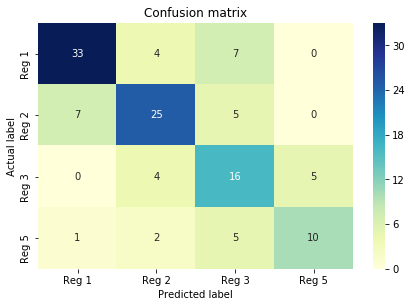

In [42]:
pretty_print_performance(test_y, test_pred_multi)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
C = np.logspace(-4, 4, 15)
hyperparameters = dict(C=C)
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)

# Best Model is the model picked with the optimal C retrained on the
# entire training data.

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 0.2682695795279725


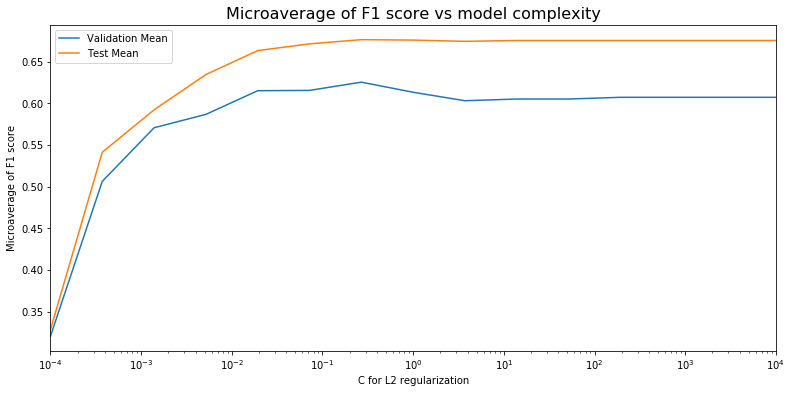

In [28]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs model complexity",
          fontsize=16)

plt.xlabel("C for L2 regularization")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
plt.xscale("log")
ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Test Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

## Confusion matrix for Cross Validated Regularization

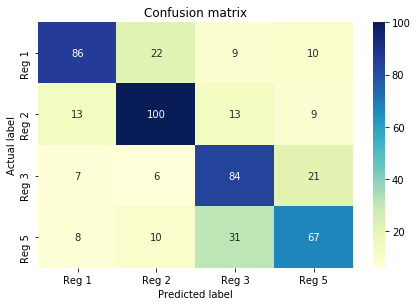

In [34]:
train_pred_multi = best_model.predict(train_X)
pretty_print_performance(train_y, train_pred_multi, False)

## Error Analysis